# Project 5 Part 2 Vehicle Detection Pipeline
This is second part of the project after classifier has already been trained. The cell below imports python library used in the project and load the SVM classifier that is already been trained.

In [1]:
import glob
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from collections import deque
from sklearn.externals import joblib

#load classifier
svc = joblib.load('Linearsvc.pk1')
X_scaler = joblib.load('normalize_const.pk1')
%matplotlib inline


Next cell, we defined the functions to extract features from the image. Three types of features : HOG, color histogram, and reduced size pixel intensities.
For HOG, built-in function from SKimage library is used.
Here, I extracted HOG features from all three channels.

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size = (32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins = 32, bins_range = (0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True

    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)        

    #Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image,spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image,nbins = hist_bins)
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In the next cell, more functions are defined that will be used for searching cars in the given frame and draw bounding boxes around it. 

In [3]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list =[]):
    
    # Compute the span of the region to be searched  
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    #nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    #ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(x_span/nx_pix_step) - 1
    ny_windows = np.int(y_span/ny_pix_step) - 1 
   
    # Loop through finding x and y window positions
    for ystep in range(ny_windows):
        for xstep in range(nx_windows):
    #       Note: you could vectorize this step, but in practice
    #       you'll be considering windows one by one with your
    #       classifier, so looping makes sense
            # Calculate each window position
            startx = xstep*nx_pix_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ystep*ny_pix_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', spatial_size=(32, 32), 
                   hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=12,
                   cell_per_block=2, hog_channel='ALL'):

    #1) Create an empty list to receive positive detection windows
    on_windows = []

    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier        
        test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)       
    #8) Return windows for positive detections
    return on_windows

The next set of functions are used for filtering out fale positives and consolidating multiple detections of a same car.

It's important to note that I check for a minimum size of car box before actually passing it to drawing. The minimum car box size criteria is 75 x 50 pixels

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        width = abs(bbox[1][0] - bbox[0][0])
        height = abs(bbox[1][1] - bbox[0][1])    
        # check for bounding box size before drawing the box
        if (width >= 75 and height >= 50):
            cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)
    # Return the image
    return img

Since cars in the image can appear anywhere at any size, multiple window sizes need to be used for searching. 
It is not clear what window sizes to be used, so I tried lot of different window sizes and then tested them on a test image. 
After multiple trials, I settled on four different search window sizes. Then, I further restricted these windows to specific regions of the image. Again, I did multiple trials to settle on region sizes and window overlaps.

158


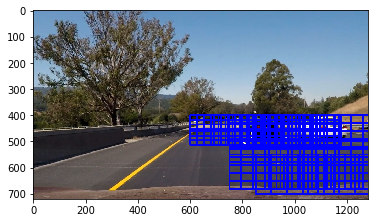

In [5]:
image = mpimg.imread('test6.jpg')    

draw_image1 = np.copy(image)

# scale .jpg image to match with .png(scaled 0 to 255)
image = image.astype(np.float32)/255

window_list = [] 

xy_window_list = [[90,60],[150,100],[180,130],[200,150]]
y_start_stop_list = [[400,500],[400,650],[550,650],[550,650]]
x_start_stop_list = [[600,1150],[750,1270],[850,1280],[850,1280]]

for i in range(len(xy_window_list)):
    y_start_stop = y_start_stop_list[i]
    x_start_stop = x_start_stop_list[i]
    xy_window = xy_window_list[i]
    
    window_list = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                   xy_window=xy_window, xy_overlap=(0.7, 0.7), window_list = window_list)

print(len(window_list))

window_img1 = draw_boxes(draw_image1, window_list, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img1)


Show all bounding boxes where cars are detected in a sample image

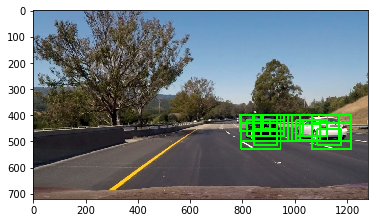

In [6]:

hot_windows = search_windows(image, window_list, svc, X_scaler)                       

window_img2 = draw_boxes(draw_image1, hot_windows, color=(0, 255, 0), thick=6)    
plt.imshow(window_img2)

Apply heat map and minimum size criteria to filter out false positives and consolidate detected cars

3 cars found


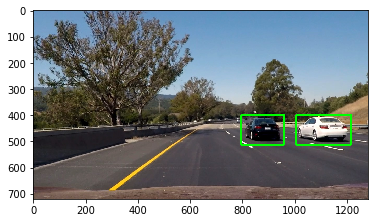

In [7]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap, 2)

labels = label(heatmap)
print(labels[1], 'cars found')

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(draw_image1, labels)
# Display the image
plt.imshow(draw_img)

Now, put together a pipeline by sequencing the functions described above and test it our on all test images.

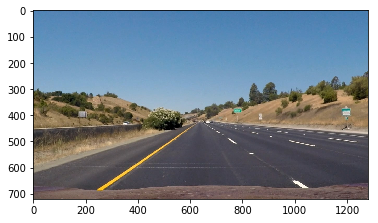

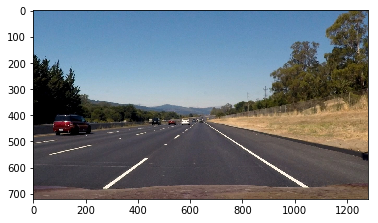

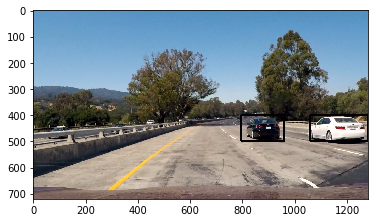

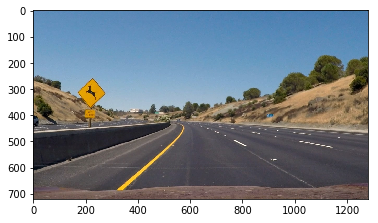

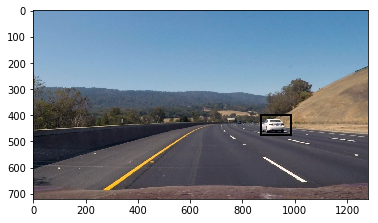

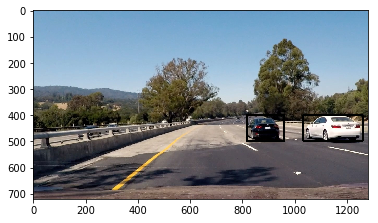

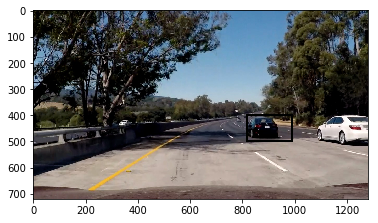

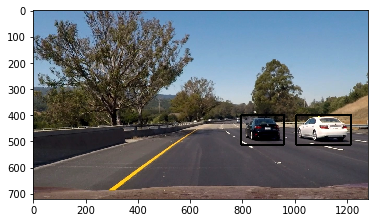

In [8]:
images = glob.glob('*.jpg')

#heatmaps = deque(maxlen = 1)
for image in images:
    img = mpimg.imread(image)
    img = img.astype(np.float32)/255
    orig_image = np.copy(img)
    hot_windows = search_windows(img, window_list, svc, X_scaler)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    window_img = draw_labeled_bboxes(orig_image, labels)
    plt.figure()
    plt.imshow(window_img)

This looks good on test images, So let's define a pipeline function for video stream. I am using threshold of 5 for heatmap.

In [9]:
def find_cars_at_scales(image):
    draw_image1 = np.copy(image)
    draw_image2 = np.copy(image)
       
    heatmap = np.zeros_like(image[:,:,0])
    image = image.astype(np.float32)/255
    
    hot_windows = search_windows(image, window_list, svc, X_scaler)                       

    window_img = draw_boxes(draw_image1, hot_windows, color=(255, 0, 0), thick=6)        
    
    heatmap = add_heat(heatmap, hot_windows) 
    heatmaps.append(heatmap)
    hm = sum(heatmaps)
    hm = apply_threshold(hm, 5)
    
    labels = label(hm)
    draw_img = draw_labeled_bboxes(draw_image2, labels)
    
    return draw_img

Process project video and save the result

In [10]:

heatmaps = deque(maxlen = 10)
clip1 = VideoFileClip("project_video.mp4",verbose=False)
white_clip = clip1.fl_image(find_cars_at_scales) #NOTE: this function expects color images!!
% time white_clip.write_videofile('VehDet_project5.mp4', audio=False,verbose=False)

print('done')

100%|█████████▉| 1260/1261 [11:02<00:00,  1.86it/s]


CPU times: user 10min 38s, sys: 18 s, total: 10min 56s
Wall time: 11min 4s
done
